In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import L1, L2
from keras.initializers import RandomUniform, GlorotUniform, GlorotNormal, Initializer

import keras.backend as K

In [2]:
# load the dataset
from utils import read_cup
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [3]:
# Define metric MEE

def MEE_keras(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [4]:
# Define Fan-in weight initialization

class FanInInitializer(Initializer):
    def __init__(self, low, high):
        self.low = low
        self.high = high

    def __call__(self, shape, dtype=None):
        if len(shape) != 2:
            raise ValueError("FanInInitializer is only applicable to 2D weight tensors.")

        input_size, units_size = shape
        return K.constant(
            np.random.uniform(
                low=self.low, 
                high=self.high, 
                size=(input_size, units_size)
            ) * 2 / np.sqrt(input_size),
            dtype=dtype
        )

    def get_config(self):
        return {"low": self.low, "high": self.high}

# Keras Implementation of Victoria

In [5]:
model = Sequential()
model.add(
    Dense(
        units=512, 
        input_dim=X_train.shape[1], 
        activation='relu', 
        kernel_regularizer=L2(1e-8), 
        kernel_initializer=FanInInitializer(low=-0.5, high=0.5)
    )
)
model.add(
    Dense(
        units=128, 
        activation='relu', 
        kernel_regularizer=L2(1e-8), 
        kernel_initializer=FanInInitializer(low=-0.5, high=0.5)
    )
)
model.add(
    Dense(
        units=3, 
        activation='linear', 
        kernel_regularizer=L2(1e-8), 
        kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05, seed=6)
    )
)

## Without k-fold cross validation

In [6]:
# Let's take also a validation set to use earlystopping
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [7]:
model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True), 
    loss='MSE', 
    metrics=MEE_keras)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.01,
    patience=250, 
    restore_best_weights=True
)
history = model.fit(
    X_train, 
    y_train, 
    epochs=3000, 
    batch_size=1, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/3000
640/640 [==============================] - 0s 492us/step - loss: 90.2454 - MEE_keras: 10.3351 - val_loss: 5.1930 - val_MEE_keras: 3.4883
Epoch 2/3000
640/640 [==============================] - 0s 427us/step - loss: 4.6788 - MEE_keras: 3.2599 - val_loss: 2.7500 - val_MEE_keras: 2.4670
Epoch 3/3000
640/640 [==============================] - 0s 429us/step - loss: 3.1068 - MEE_keras: 2.6429 - val_loss: 2.1363 - val_MEE_keras: 2.1350
Epoch 4/3000
640/640 [==============================] - 0s 424us/step - loss: 2.4066 - MEE_keras: 2.3310 - val_loss: 1.8079 - val_MEE_keras: 1.9992
Epoch 5/3000
640/640 [==============================] - 0s 417us/step - loss: 1.8913 - MEE_keras: 2.0820 - val_loss: 1.4512 - val_MEE_keras: 1.7906
Epoch 6/3000
640/640 [==============================] - 0s 413us/step - loss: 1.7078 - MEE_keras: 1.9617 - val_loss: 1.6142 - val_MEE_keras: 1.9729
Epoch 7/3000
640/640 [==============================] - 0s 408us/step - loss: 1.5789 - MEE_keras: 1.8624 - val

7/7 [==============================] - 0s 608us/step - loss: 0.2503 - MEE_keras: 0.5692
Test Loss: 0.2503
Test MEE: 0.5692


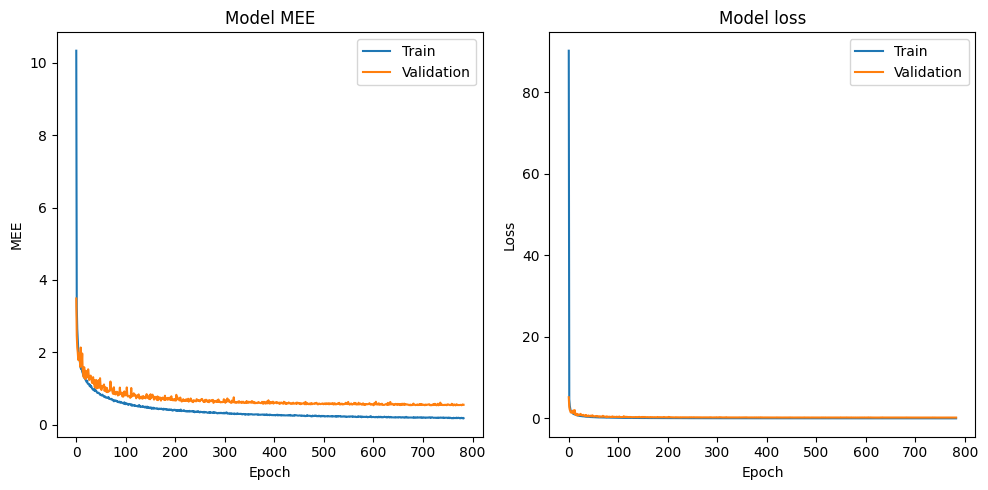

In [8]:
# test loss and mee
loss, MEE_keras = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test MEE: {MEE_keras:.4f}')

history = history.history

# plot training and validation mee values
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history['MEE_keras'])
plt.plot(history['val_MEE_keras'])
plt.title('Model MEE')
plt.ylabel('MEE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## Using k-fold cross validation

In [8]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (800, 10, 1)
y_train shape: (800, 3, 1)


In [9]:
# reshape X_train
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
print(f'X_train shape: {X_train.shape}')

# reshape y_train
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
print(f'y_train shape: {y_train.shape}')

X_train shape: (800, 10)
y_train shape: (800, 3)


In [11]:
# Define the number of folds
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate through the folds
for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    print(f"Training on fold {fold + 1}...")
    
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Compile and train the model on the current fold
    model.compile(
        optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True), 
        loss='MSE', 
        metrics=[MEE_keras]
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        min_delta=0.01,
        patience=250, 
        restore_best_weights=True 
    )
    
    history = model.fit(
        X_train_fold, 
        y_train_fold, 
        epochs=3000, 
        batch_size=1, 
        validation_data=(X_val_fold, y_val_fold), 
        callbacks=[early_stopping]
    )
    
    history = history.history

    # plot training and validation mee values
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history['MEE_keras'])
    plt.plot(history['val_MEE_keras'])
    plt.title('Model MEE')
    plt.ylabel('MEE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous-multioutput' instead.